In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

*** Program Started ***
Total images are :  926

Printing Model Summary
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 94, 94, 32)        896       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 20, 20, 128)       73856     
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 10, 10, 128)       0         
_________________________________________________________________
conv

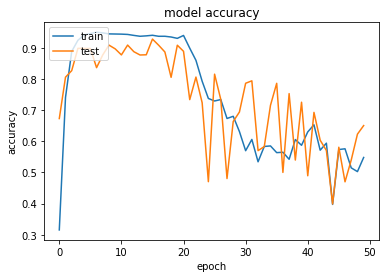

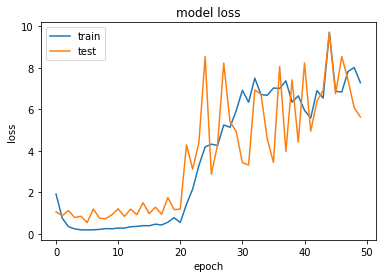

In [7]:
# Importing all the required libraries and packages here
import numpy as np
import pandas as pd
import glob
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Dense, Flatten , Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import matplotlib.pyplot as plt

print("*** Program Started ***")

# Initializing all the global variables and Paths
PathforInputImages = "/content/gdrive/My Drive/Face Recognition/Test_data_Face_Extraction"
PredictionPath = "/content/gdrive/My Drive/Face Recognition/Prediction/"
PredictionImage = "Atal003Face.jpg"
PlotGraph = "/content/gdrive/My Drive/Face Recognition/Output/GitHub/"
ModelSave = "/content/gdrive/My Drive/Face Recognition/Output/GitHub/"
batch_size = 64
epochs = 50
labels = 11

# Read all the input imgaes and storing all the images pixel values into DataFrame
def XtrainXtest():  
    i = 0
    Dict_Pixels = {}
    RGBPixels = []
    PersonName = []
    ParentFolders = os.listdir(PathforInputImages)
    while i < len(ParentFolders):
        FinalPath = PathforInputImages+'/'+ParentFolders[i]+'/*.jpg'
        Images=glob.glob(FinalPath)
        for OneImage in Images:
            ReadImage = Image.open(OneImage)
            ArrayImage = np.asarray(ReadImage)
            RGBPixels.append(ArrayImage)
            PersonName.append(ParentFolders[i])
        i = i + 1
    Dict_Pixels={'Name of Person': PersonName,'RGB_PixelsValues':RGBPixels}
    ParentDataFrame=pd.DataFrame(Dict_Pixels)
    print("Total images are : ",len(ParentDataFrame))                      
    return ParentDataFrame

# Splitting of mainDataFrame into Train and Test DataSet
def YtrainYtest(mainDF):
    UniqueNames=mainDF['Name of Person'].unique()
    trainRGB = []
    testRGB =  []
    trainName =[]
    testName  =[]
    
    # Creating mini dataframe out of main DataFrame to split the respective pics
    for uniquename in UniqueNames:
        a=mainDF[mainDF['Name of Person']==uniquename]
        (trainRGB1, testRGB1, trainName1, testName1) = train_test_split(a['RGB_PixelsValues'].values,a[('Name of Person')].values, test_size=0.1, random_state=42)
        trainRGB.append(trainRGB1)
        testRGB.append(testRGB1)
        trainName.append(trainName1)
        testName.append(testName1)
    
    # Creating a single list from the Nested List
    trainRGB= [item for sublist in trainRGB for item in sublist]
    trainName = [item for sublist in trainName for item in sublist]
    testRGB= [item for sublist in testRGB for item in sublist]
    testName = [item for sublist in testName for item in sublist]

    # Converting into numpy array so that reshape could work
    a = len(trainRGB)
    Training_data=a
    trainRGB=np.asarray(trainRGB)
    trainRGB = trainRGB.reshape(a,96,96,3)
    b=len(testRGB)
    Test_data=b
    testRGB=np.asarray(testRGB)
    testRGB = testRGB.reshape(b,96,96,3)

    # Framing Labels for Training Data
    i=0
    Labeltrain=np.zeros(shape=(len(trainRGB),len(UniqueNames)))    
    while i<len(trainName):
        col_name_train=np.where(UniqueNames==trainName[i])
        Labeltrain[i][col_name_train]=1
        i=i+1
    
    #Framing Labels for Test Data
    j=0
    Labeltest=np.zeros(shape=(len(testRGB),len(UniqueNames)))    
    while j<len(testName):
        col_name_test=np.where(UniqueNames==testName[j])
        Labeltest[j][col_name_test]=1
        j=j+1
    
    # Returning xTrain=trainRGB, xTest=testRGB, yTrain=Labeltrain, yTest=Labeltest and person names as UniqueNames to the Model
    return trainRGB, testRGB, Labeltrain, Labeltest, UniqueNames

def FaceRecognition(xTrain, xTest, yTrain, yTest):
    # Initialising the CNN
    classifier = Sequential()
    # Step 1 - Convolution
    classifier.add(Conv2D(32, (3, 3), input_shape = (96, 96, 3), activation = 'relu'))
    # Step 2 - Pooling
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    # Adding a second convolutional layer
    classifier.add(Conv2D(64, (3, 3), activation = 'relu'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    # Third convolutional layer
    classifier.add(Conv2D(128, (3, 3), activation = 'relu'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    # Fourth convolutional layer
    classifier.add(Conv2D(256, (3, 3), activation = 'relu'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    # Fifth convolutional layer
    classifier.add(Conv2D(256, (3, 3), activation = 'relu'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    # Step 3 - Flattening
    classifier.add(Flatten())
    # Step 4 - Full connection
    classifier.add(Dense(units = 512, activation = 'relu'))
    classifier.add(Dropout(0.5))
    classifier.add(Dense(units = labels, activation = 'softmax'))
    # Compiling the CNN
    classifier.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    print("\nPrinting Model Summary")
    classifier.summary()

    # Data augmentation
    train_datagen = ImageDataGenerator(rescale = 1./255, rotation_range=20, shear_range = 0.15,
                    zoom_range = 0.15, width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True, fill_mode="nearest")
    test_datagen = ImageDataGenerator(rescale = 1./255)
    train_datagen.fit(xTrain)
    test_datagen.fit(xTest)
    
    # Training the Model
    history = classifier.fit_generator(train_datagen.flow(xTrain, yTrain),
                         steps_per_epoch = len(xTrain),
                         epochs = epochs,
                         verbose=1,
                         validation_data = test_datagen.flow(xTest, yTest),
                         validation_steps = len(xTest))
    
    # Prediction Image
    test_image = image.load_img(PredictionPath + PredictionImage, target_size = (96, 96))
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis = 0)
    result = classifier.predict(test_image)
    
    # Printing Result
    FinalResult = pd.DataFrame({'Name': UniqueNames})
    FinalResult['Result'] = result[0]
    print("\n")
    print(FinalResult)
    FinalResult=FinalResult.sort_values(['Result'])
    FinalResult=FinalResult.tail(1)
    print ("\nHere is the Prediction Result : ",FinalResult['Name'].to_string(index=False))
    Predicted_Image=FinalResult['Name'].to_string(index=False)
    classifier.save(ModelSave + "Model_Saved.h5")
    return history

# Ploting graph for Model accuracy
def accuracy_plot(history):
    fig = plt.figure()
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    fig.savefig(PlotGraph + 'Epoch_accuracy_graph.png')

# Ploting graph for Model loss
def loss_plot(history):
    fig = plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    fig.savefig(PlotGraph + 'Epoch_loss_graph.png')
    
# Calling all the Pre-defined functions  
XtrainXtestReturns = XtrainXtest()
xTrain, xTest, yTrain, yTest, UniqueNames = YtrainYtest(XtrainXtestReturns)
history = FaceRecognition(xTrain, xTest, yTrain, yTest)
accuracy_plot(history)
loss_plot(history)
print("*** Ended Started ***")